<a href="https://colab.research.google.com/github/neilnielsen/language_modelling/blob/master/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import defaultdict
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [0]:
import gensim
from gensim.models import Word2Vec, KeyedVectors

In [0]:
!pip install --upgrade pip setuptools wheel
!pip install -I tensorflow
!pip install -I keras

In [3]:
import keras.backend as k
from keras.utils import plot_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.layers import Embedding
from keras.layers import LSTM, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

from keras.regularizers import l1

from keras.initializers import Constant
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
!wget -P / -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-03-25 17:23:23--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.15.46
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.15.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

oogleNews-vectors-n 100%[===================>]   1.53G  44.5MB/s    in 36s     

2020-03-25 17:24:00 (43.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [44]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
max_features = 1000
maxlen = 500
embedding_size = 300

In [0]:
df_train = pd.read_csv("electronics_train.csv")

In [0]:
df_dev_1 = pd.read_csv("home_tune.csv")
df_dev_2 = pd.read_csv("toys_tune.csv")
df_dev = pd.concat([df_dev_1, df_dev_2])

In [0]:
df_train.dropna(inplace=True)
df_dev.dropna(inplace=True)

In [0]:
def clean_text(text, lower=True):
    if type(text) == float:
        return ' '
    cleaned = BeautifulSoup(text).get_text()
    cleaned = re.sub(r'&quot;', '"', cleaned)
    cleaned = re.sub("[^a-zA-Z]"," ", cleaned)
    if lower:
        cleaned = cleaned.lower().split()
    else:
        cleaned = cleaned.split()
    
    stops = set(stopwords.words("english"))
    cleaned = [w for w in cleaned if not w in stops]
    return cleaned

In [18]:
df_train["reviewText_clean"] = df_train.reviewText.apply(clean_text)
df_train["summary_clean"] = df_train.summary.apply(clean_text)
df_dev["reviewText_clean"] = df_dev.reviewText.apply(clean_text)
df_dev["summary_clean"] = df_dev.summary.apply(clean_text)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.flickr.com/photos/daovang/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B0026JGDMC/ref=cm_cr_rev_prod_title/175-2885001-8287551" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/li

In [0]:
polarity_dict = {'positive': 1, 'negative': 0}

In [0]:
df_train["polarity_enc"] = df_train.polarity.map(polarity_dict)
df_dev["polarity_enc"] = df_dev.polarity.map(polarity_dict)

In [0]:
def create_pos_tags(text_list):
    text_str = ' '.join(text_list)
    tags = nltk.pos_tag(text_str)
    tags_stripped = [tag[1] for tag in tags]
    return tags_stripped

In [0]:
df_train['POS_tags'] = df_train.reviewText_clean.apply(create_pos_tags)
df_train['POS_tags_sum'] = df_train.summary_clean.apply(create_pos_tags)

In [0]:
df_train.to_pickle('df_train_attr.pickle')

In [0]:
df_pos = pd.Series(sum([item for item in df_train.POS_tags], [])).value_counts()

In [0]:
df_pos

In [0]:
def generate_review_lines(df, col):
    reviews = df[col].tolist()
    
    review_lines = list()
    
    for rev in reviews:
        tokens = [word for word in rev if word.isalpha()]
        review_lines.append(tokens)
    return review_lines

In [0]:
review_lines_rev = generate_review_lines(df_train, 'reviewText_clean')
review_lines_sum = generate_review_lines(df_train, 'summary_clean')

review_lines_rev_dev = generate_review_lines(df_dev, 'reviewText_clean')
review_lines_sum_dev = generate_review_lines(df_dev, 'summary_clean')

In [0]:
emb_model_rev = Word2Vec(review_lines_rev, min_count=1, size=300)
emb_model_sum = Word2Vec(review_lines_sum, min_count=1, size=300)

In [23]:
# Put these aside
emb_model_rev = Word2Vec.load("300features_40minwords_10context")
emb_model_sum = Word2Vec.load("300features_40minwords_10context_SUMMARY")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
tok_obj_rev = Tokenizer()
tok_obj_rev.fit_on_texts(review_lines_rev)
sequences_rev = tok_obj_rev.texts_to_sequences(review_lines_rev)
sequences_rev_dev = tok_obj_rev.texts_to_sequences(review_lines_rev_dev)

tok_obj_sum = Tokenizer()
tok_obj_sum.fit_on_texts(review_lines_sum)
sequences_sum = tok_obj_sum.texts_to_sequences(review_lines_sum)
sequences_sum_dev = tok_obj_sum.texts_to_sequences(review_lines_sum_dev)

In [0]:
sequences_rev = tok_obj_rev.texts_to_sequences(review_lines_rev)
sequences_sum = tok_obj_sum.texts_to_sequences(review_lines_sum)

In [0]:
word_index_rev = tok_obj_rev.word_index
rev_pad = sequence.pad_sequences(sequences_rev, maxlen = max_features)
rev_pad_dev = sequence.pad_sequences(sequences_rev_dev, maxlen = max_features)

word_index_sum = tok_obj_sum.word_index
sum_pad = sequence.pad_sequences(sequences_sum, maxlen = max_features)
sum_pad_dev = sequence.pad_sequences(sequences_sum_dev, maxlen = max_features)

sentiment = df_train.polarity_enc.values
sentiment_dev = df_dev.polarity_enc.values

In [0]:
def create_emb_matrix(emb_model, tok_obj, word_index, google=False):
    num_words = len(word_index)+1
    emb_matrix = np.zeros((num_words, embedding_size))
    counter = 0
    unks = list()
    for word, i in word_index.items():
        if i > num_words:
            continue
        try:
            if not google:
                emb_vector = emb_model.wv[word]
                emb_matrix[i] = emb_vector
            else:
                emb_vector = emb_model.word_vec(word)
                emb_matrix[i] = emb_vector
        except KeyError:
            counter += 1
            unks.append(word)
            continue
    print(counter)
    return emb_matrix, unks

In [71]:
emb_matrix_rev, rev_unks = create_emb_matrix(emb_model_rev, tok_obj_rev, word_index_rev)
emb_matrix_sum, sum_unks = create_emb_matrix(emb_model_sum, tok_obj_sum, word_index_sum)

0
0


In [85]:
emb_matrix_rev_g, rev_unks_g = create_emb_matrix(word2vec, tok_obj_rev, word_index_rev, google=True)
emb_matrix_sum_g, sum_unks_g = create_emb_matrix(word2vec, tok_obj_sum, word_index_sum, google=True)

#del word2vec

75778
5684


In [84]:
rev_unks_g[:10]

['netgear',
 'belkin',
 'sandisk',
 'rca',
 'olympus',
 'sennheiser',
 'onkyo',
 'sansa',
 'magellan',
 'sdhc']

In [0]:
with open('train_cluster_1000.pickle', 'rb') as handle:
  clus_train = pickle.load(handle)
    
with open('dev_cluster_1000.pickle', 'rb') as handle:
  clus_dev = pickle.load(handle)

In [0]:
assert rev_pad.shape == clus_train.shape
assert rev_pad_dev.shape == clus_dev.shape

In [76]:
k.clear_session()

In [0]:
in_review = Input(shape=(max_features,), name = 'reviewText')
in_summary = Input(shape=(max_features,), name = 'summary')

emb_rev = Embedding(len(word_index_rev)+1, 
                    embedding_size, 
                    embeddings_initializer=Constant(emb_matrix_rev),
                    input_length=max_features,
                    trainable=False
                   )(in_review)

emb_sum = Embedding(len(word_index_sum)+1, 
                    embedding_size, 
                    embeddings_initializer=Constant(emb_matrix_sum),
                    input_length=max_features,
                    trainable=False
                   )(in_summary)

fe_own = concatenate([(emb_rev), (emb_sum)])

x = Conv1D(128, 5, activation='relu')(fe_own)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
x_own = Dense(500, activation='relu')(x)


emb_rev_g = Embedding(len(word_index_rev)+1, 
                    embedding_size, 
                    embeddings_initializer=Constant(emb_matrix_rev_g),
                    input_length=max_features,
                    trainable=False
                   )(in_review)

emb_sum_g = Embedding(len(word_index_sum)+1, 
                    embedding_size, 
                    embeddings_initializer=Constant(emb_matrix_sum_g),
                    input_length=max_features,
                    trainable=False
                   )(in_summary)

fe_g = concatenate([(emb_rev_g), (emb_sum_g)])

x = Conv1D(128, 5, activation='relu')(fe_g)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
x_g = Dense(500, activation='relu')(x)

x = concatenate([x_own, x_g])
x = Dense(500)(x)


in_clus = Input(shape=(max_features,), name='cluster')
clus_layer = Dense(1000)(in_clus)

x_clus = Dense(512, activation='relu')(clus_layer)

x = concatenate([(x), (x_clus)])

x = Dense(256)(x)

preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[in_review, in_summary, in_clus], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

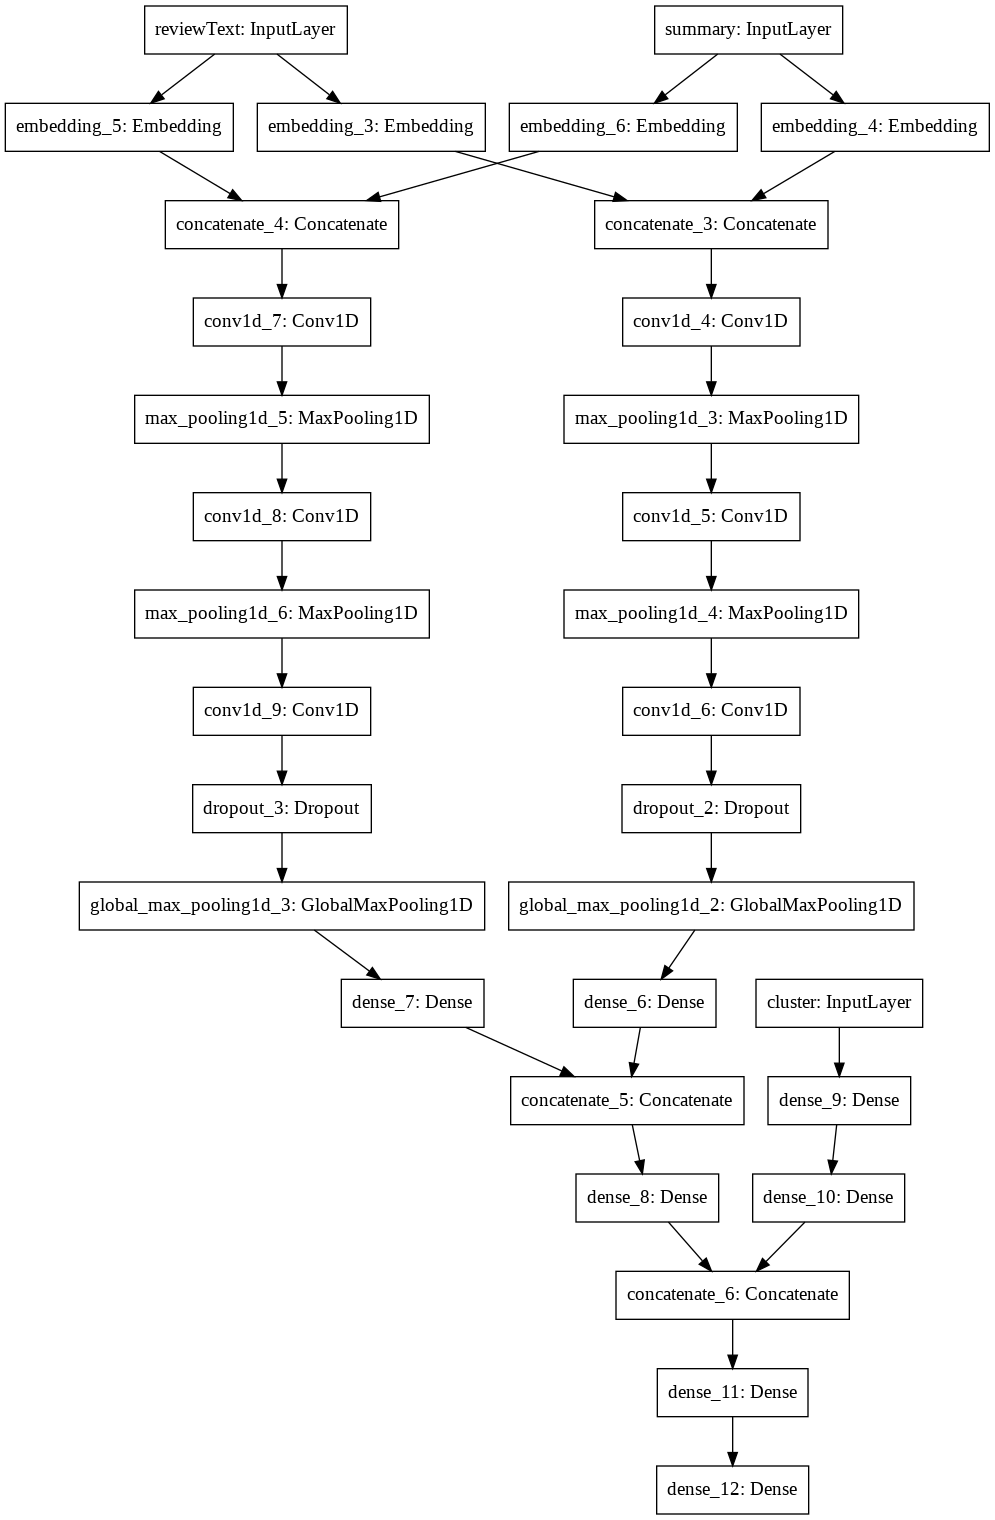

In [91]:
plot_model(model)

In [88]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reviewText (InputLayer)         (None, 1000)         0                                            
__________________________________________________________________________________________________
summary (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1000, 300)    38589300    reviewText[0][0]                 
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1000, 300)    6503700     summary[0][0]                    
____________________________________________________________________________________________

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [90]:
history = model.fit([rev_pad, sum_pad, clus_train], 
                    sentiment, 
                    batch_size=256,
                    epochs=5, 
                    validation_data=([rev_pad_dev, sum_pad_dev, clus_dev], sentiment_dev), 
                    verbose=1, 
                    #callbacks=[es]
                    )

Train on 199802 samples, validate on 2999 samples
Epoch 1/5
199802/199802 [==============================] - 118s 590us/step - loss: 0.2919 - acc: 0.8821 - val_loss: 0.3094 - val_acc: 0.8710
Epoch 2/5
199802/199802 [==============================] - 114s 570us/step - loss: 0.2037 - acc: 0.9192 - val_loss: 0.2844 - val_acc: 0.8880
Epoch 3/5
199802/199802 [==============================] - 114s 568us/step - loss: 0.1623 - acc: 0.9363 - val_loss: 0.2941 - val_acc: 0.8856
Epoch 4/5
 12032/199802 [>.............................] - ETA: 1:46 - loss: 0.0932 - acc: 0.9641

KeyboardInterrupt: ignored

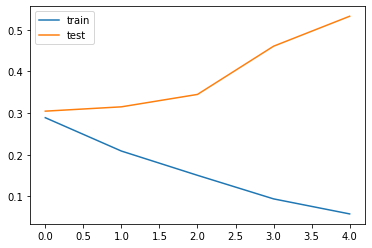

In [0]:
  plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig('loss')
plt.show()

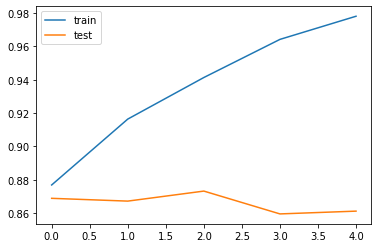

In [0]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()